In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Available device : {device}")

# Configurations
batch_size = 128
latent_dim = 50
epochs = 30
lr = 2e-4

Available device : cuda


In [3]:
# Dataset (MNIST)
# ----------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 15.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 501kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.54MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.75MB/s]


In [4]:
# Generator
# ----------------------------
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z)

In [5]:
# Encoder
# ----------------------------
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, latent_dim)
        )

    def forward(self, x):
        return self.net(x)

In [6]:
# Discriminator (Joint: x, z)
# ----------------------------
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784 + latent_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 1)  # No sigmoid! BCEWithLogitsLoss handles that
        )

    def forward(self, x, z):
        xz = torch.cat([x, z], dim=1)
        return self.net(xz)

In [7]:
# Initialize models
# ----------------------------
G = Generator().to(device)
E = Encoder().to(device)
D = Discriminator().to(device)

In [8]:
# Optimizers and Loss
# ----------------------------
bce_loss = nn.BCEWithLogitsLoss()
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_GE = optim.Adam(list(G.parameters()) + list(E.parameters()), lr=lr, betas=(0.5, 0.999))

In [9]:
k = 3
p = 1
os.makedirs("bigan", exist_ok=True)

In [10]:
# Training Loop
# ----------------------------
for epoch in range(1, epochs + 1):
    for i, (x_real, _) in enumerate(train_loader):
        x_real = x_real.to(device)
        batch_size = x_real.size(0)

        # Sample z from prior
        z_real = torch.randn(batch_size, latent_dim, device=device)

        # ----------------------
        # 1. Train Discriminator
        # ----------------------
        for _ in range(p):
          G.eval()
          E.eval()
          D.train()

          x_fake = G(z_real).detach()
          z_fake = E(x_real).detach()

          D_real = D(x_real, z_fake)
          D_fake = D(x_fake, z_real)

          label_real = torch.ones_like(D_real)
          label_fake = torch.zeros_like(D_fake)

          loss_D = bce_loss(D_real, label_real) + bce_loss(D_fake, label_fake)

          optimizer_D.zero_grad()
          loss_D.backward()
          optimizer_D.step()

        # --------------------------
        # 2. Train Generator + Encoder
        # --------------------------
        for _ in range(k):
          G.train()
          E.train()
          D.eval()

          x_fake = G(z_real)
          z_fake = E(x_real)

          D_real = D(x_real, z_fake)
          D_fake = D(x_fake, z_real)

          loss_GE = bce_loss(D_real, label_fake) + bce_loss(D_fake, label_real)

          optimizer_GE.zero_grad()
          loss_GE.backward()
          optimizer_GE.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{epochs}] Batch {i}/{len(train_loader)}",
                  f"Loss D: {loss_D.item():.4f}, Loss GE: {loss_GE.item():.4f}")

        # Save samples every epoch
        G.eval()
        with torch.no_grad():
            z = torch.randn(64, latent_dim, device=device)
            samples = G(z)
            samples = samples * 0.5 + 0.5  # Denormalize
            save_image(samples, f"bigan/epoch_{epoch}.png", nrow=8)
        G.train()

Epoch [1/30] Batch 0/469 Loss D: 1.4249, Loss GE: 1.2686
Epoch [1/30] Batch 100/469 Loss D: 0.9395, Loss GE: 0.4155
Epoch [1/30] Batch 200/469 Loss D: 0.7746, Loss GE: 0.0193
Epoch [1/30] Batch 300/469 Loss D: 0.3244, Loss GE: 0.1588
Epoch [1/30] Batch 400/469 Loss D: 0.2288, Loss GE: 0.2537
Epoch [2/30] Batch 0/469 Loss D: 0.1128, Loss GE: 0.3215
Epoch [2/30] Batch 100/469 Loss D: 0.0855, Loss GE: 0.3230
Epoch [2/30] Batch 200/469 Loss D: 0.1647, Loss GE: 0.6631
Epoch [2/30] Batch 300/469 Loss D: 0.1063, Loss GE: 1.4363
Epoch [2/30] Batch 400/469 Loss D: 0.0512, Loss GE: 0.3763
Epoch [3/30] Batch 0/469 Loss D: 0.1307, Loss GE: 0.2289
Epoch [3/30] Batch 100/469 Loss D: 0.1460, Loss GE: 2.5864
Epoch [3/30] Batch 200/469 Loss D: 0.0559, Loss GE: 0.4271
Epoch [3/30] Batch 300/469 Loss D: 0.0203, Loss GE: 0.2547
Epoch [3/30] Batch 400/469 Loss D: 0.0127, Loss GE: 0.5066
Epoch [4/30] Batch 0/469 Loss D: 0.0237, Loss GE: 0.3315
Epoch [4/30] Batch 100/469 Loss D: 0.0123, Loss GE: 0.1955
Epoch

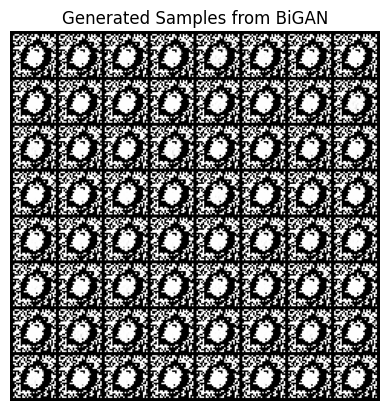

In [11]:
# Generate Samples for Visualization
# ----------------------------
def show_samples():
    G.eval()
    with torch.no_grad():
        z = torch.randn(64, latent_dim, device=device)
        x_gen = G(z).view(-1, 1, 28, 28).cpu()
        grid = torchvision.utils.make_grid(x_gen, nrow=8)
        plt.imshow(grid.permute(1, 2, 0).squeeze())
        plt.axis('off')
        plt.title("Generated Samples from BiGAN")
        plt.show()

show_samples()